# COSC2789-Practical Data Science
# Assignment 2: Data Modelling
### Due date: Jan 4, 2020
### Lecturer: Vo Ngoc Yen Nhi


###

### Student: Nguyen Quang Linh
### ID: s3697110


###

#### This notebook is the submission for the assignment 2. 

This notebook is going to explore the data of books as indeX_trained on Goodreads. From this, models can be builed to predict the average rating of these books. 

#### Acknowlegdements  
Books are scraped from a list titles the "Best Books Ever" which can be found here https://www.goodreads.com/list/show/1.Best_Books_Ever page. We thank Kaggle Community for providing this dataset and Goodreads for housing the data.


# Import Libraries

In [1]:
#import necessary libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.style as style
import seaborn as sns

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import time
import warnings 
import re
import joblib
import pickle
# seaborn theme
sns.set_theme(style="darkgrid")
style.use('fivethirtyeight')

warnings.filterwarnings("ignore")

In [2]:
# natural langue process libraries
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_leX_trainicon')
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\quang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading vader_leX_trainicon: Package
[nltk_data]     'vader_leX_trainicon' not found in index


In [3]:
# maX_train column
pd.options.display.max_columns = None

# Task 1.1: Data Prepatation

### Detecting unicode 

In [4]:
# libraries to detect encoding 
import chardet
import glob

# for any csv file, print filename and guessing unicode detection 
print("Filename: ".ljust(45) + "Unicode: ")
for filename in glob.glob('data/*.csv'):
    with open(filename, 'rb') as rawdata:
        result = chardet.detect(rawdata.read(40000))
        
        print( filename.ljust(45),  result['encoding'])

Filename:                                    Unicode: 
data\sampleSubmission.csv                     ascii
data\X_test.csv                               utf-8
data\X_test_clean.csv                         utf-8
data\X_train.csv                              utf-8
data\X_train_clean.csv                        utf-8
data\y_train.csv                              ascii


This function is referred from [this](https://www.kaggle.com/rtatman/character-encodings-tips-tricks) article by Rachael Tatman (2018).

### Quick look on training dataset

In [5]:
#import training data.
X_train = pd.read_csv("data/X_train.csv", encoding = 'utf-8')

#print data
X_train.head(2)

,id,title,link,series,cover_link,author,author_link,rating_count,review_count,number_of_pages,date_published,publisher,original_title,genre_and_votes,isbn,isbn13,asin,settings,characters,awards,amazon_redirect_link,worldcat_redirect_link,recommended_books,books_in_series,description
0,2533958,Frost/Nixon,https://www.goodreads.com//book/show/2533958.F...,NaN,https://i.gr-assets.com/images/S/compressed.ph...,David Frost,https://www.goodreads.com/author/show/264173.D...,523,51,338.0,December 31st 1975,MacMillan,Frost/Nixon: Behind the Scenes of the Nixon In...,"History 42, Nonfiction 33, Politics 28, Biogra...",0230531148,9780230531147,NaN,NaN,"Richard Nixon, David Frost",NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"13167112, 13167112, 29429295, 2074322, 3025937...",NaN,Including hilarious tales of the people he enc...
1,16071790,Just What Kind of Mother Are You?,https://www.goodreads.com//book/show/16071790-...,NaN,https://i.gr-assets.com/images/S/compressed.ph...,Paula Daly,https://www.goodreads.com/author/show/6175529....,10092,1236,320.0,April 28th 2013,Doubleday Canada,Just What Kind of Mother Are You?,"Mystery 136, Fiction 122, Thriller 90, Suspens...",0385680074,9780385680073,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/1?...,https://www.goodreads.com//book_link/follow/8?...,"42614702, 42614702, 42182331, 45730306, 379129...",NaN,A searing and sinister thriller for readers wh...


### Quick look on testing data

In [6]:
# import testing data.
X_test = pd.read_csv("data/X_test.csv", encoding = "utf-8")
X_test.head(2)

,id,title,link,series,cover_link,author,author_link,rating_count,review_count,number_of_pages,date_published,publisher,original_title,genre_and_votes,isbn,isbn13,asin,settings,characters,awards,amazon_redirect_link,worldcat_redirect_link,recommended_books,books_in_series,description
0,6333213,The Way of the Bow,https://www.goodreads.com//book/show/6333213-t...,NaN,https://i.gr-assets.com/images/S/compressed.ph...,Paulo Coelho,https://www.goodreads.com/author/show/566.Paul...,2179,180,76.0,2003,NaN,The Way of the Bow,"Fiction 39, Philosophy 15, Inspirational 6, Se...",0557010071,9.780557e+12,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"52049749, 52049749, 9242583, 50058600, 1194740...",NaN,âThe Way of the Bowâ relates the story of ...
1,493553,The Silver Child,https://www.goodreads.com//book/show/493553.Th...,(Silver Sequence #1),https://i.gr-assets.com/images/S/compressed.ph...,Cliff McNish,https://www.goodreads.com/author/show/27813.Cl...,874,84,192.0,August 1st 2003,First Avenue Editions,The Silver Child,"Fantasy 30, Young Adult 15, Science Fiction 14...",082256503X,9.780823e+12,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"13542616, 13542616, 13274082, 16072988, 58085,...","36448526, 36448541",Six children leave the comfort of their homes....


### Quick look on target feature column 

In [7]:
# import label column (average_rating)
y_train = pd.read_csv("data/y_train.csv",encoding = "ascii")
y_train.head()

,id,average_rating
0,2533958,3.62
1,16071790,3.80
2,13825165,3.55
3,18061,4.24
4,3766428,4.33


# Describe the Datasets

In [8]:
print (f"Train set  has {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print (f"Test set  has {X_test.shape[0]} rows and {X_test.shape[1]} columns")
print (f"Target feature set has {y_train.shape[0]} rows")

Train set  has 41759 rows and 25 columns
Test set  has 10440 rows and 25 columns
Target feature set has 41759 rows


- It is obvious that two dataset train and set has the same numbers of columns 

- Target rows are equal to training data rows. 

## X_train Dataset

In [9]:
# training dataset info
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41759 entries, 0 to 41758
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      41759 non-null  int64  
 1   title                   41759 non-null  object 
 2   link                    41759 non-null  object 
 3   series                  18647 non-null  object 
 4   cover_link              41273 non-null  object 
 5   author                  41759 non-null  object 
 6   author_link             41759 non-null  object 
 7   rating_count            41759 non-null  int64  
 8   review_count            41759 non-null  int64  
 9   number_of_pages         39886 non-null  float64
 10  date_published          41071 non-null  object 
 11  publisher               38866 non-null  object 
 12  original_title          31463 non-null  object 
 13  genre_and_votes         39521 non-null  object 
 14  isbn                    32284 non-null

## Brief Descriptions: 

- There are four numerical data columns including int64 and float64 datatypes

- The rest is all object datatype including string values

In [10]:
# describe the columsn with object datatype
X_train.describe(include='object').T

,count,unique,top,freq
title,41759,40047,Legacy,11
link,41759,41759,https://www.goodreads.com//book/show/26026066-...,1
series,18647,18197,(Sherlock Holmes),12
cover_link,41273,41273,https://i.gr-assets.com/images/S/compressed.ph...,1
author,41759,23482,Nora Roberts,65
author_link,41759,19803,https://www.goodreads.com/author/show/3389.Ste...,82
date_published,41071,8299,2009,371
publisher,38866,9514,Vintage,457
original_title,31463,30516,Legacy,8
genre_and_votes,39521,37957,Fiction 1user,70


- It can be seen that there are large amounts of unique values for each object datatypes. 

In [11]:
# describe all numerical data columns 
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,41759.0,1.012620e+07,1.162310e+07,1.0,363987.5,6365996.0,17373246.0,54442989.0
rating_count,41759.0,1.893641e+04,1.204193e+05,0.0,346.0,2295.0,9271.0,6801077.0
review_count,41759.0,1.011812e+03,4.129329e+03,0.0,32.0,164.0,626.5,169511.0
number_of_pages,39886.0,3.293661e+02,2.509911e+02,0.0,211.0,304.0,393.0,11095.0


There are some quite jumps from 25% to maX_train in these numerical columns.

# X_test Dataset

#### With the same flows as training data 

In [12]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10440 entries, 0 to 10439
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10440 non-null  int64  
 1   title                   10440 non-null  object 
 2   link                    10440 non-null  object 
 3   series                  4672 non-null   object 
 4   cover_link              10319 non-null  object 
 5   author                  10440 non-null  object 
 6   author_link             10440 non-null  object 
 7   rating_count            10440 non-null  int64  
 8   review_count            10440 non-null  int64  
 9   number_of_pages         9983 non-null   float64
 10  date_published          10268 non-null  object 
 11  publisher               9697 non-null   object 
 12  original_title          7787 non-null   object 
 13  genre_and_votes         9838 non-null   object 
 14  isbn                    8032 non-null 

- In training dataset, 'isbn13' is object values. But testing dataset shows that it is float64 datatypes.
- It must be converted into object to prepare the dataset.


In [13]:
# cast 'isbn13' into object values
isbn13_float = X_test.isbn13
isbn13_float = X_test.isbn13.astype('object')

In [14]:
# review X_test info
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10440 entries, 0 to 10439
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10440 non-null  int64  
 1   title                   10440 non-null  object 
 2   link                    10440 non-null  object 
 3   series                  4672 non-null   object 
 4   cover_link              10319 non-null  object 
 5   author                  10440 non-null  object 
 6   author_link             10440 non-null  object 
 7   rating_count            10440 non-null  int64  
 8   review_count            10440 non-null  int64  
 9   number_of_pages         9983 non-null   float64
 10  date_published          10268 non-null  object 
 11  publisher               9697 non-null   object 
 12  original_title          7787 non-null   object 
 13  genre_and_votes         9838 non-null   object 
 14  isbn                    8032 non-null 

In [15]:
X_test.describe(include='object').T

,count,unique,top,freq
title,10440,10295,Selected Poems,4
link,10440,10440,https://www.goodreads.com//book/show/37811512-...,1
series,4672,4627,(Star Wars Legends),5
cover_link,10319,10319,https://i.gr-assets.com/images/S/compressed.ph...,1
author,10440,7880,Nora Roberts,22
author_link,10440,7157,https://www.goodreads.com/author/show/625.Nora...,25
date_published,10268,3958,2009,91
publisher,9697,3648,Vintage,115
original_title,7787,7713,Legacy,3
genre_and_votes,9838,9605,Fiction 1user,19


In [16]:
X_test.describe()

,id,rating_count,review_count,number_of_pages,isbn13
count,1.044000e+04,1.044000e+04,10440.000000,9983.000000,7.847000e+03
mean,1.026734e+07,1.862243e+04,1017.657375,327.251227,9.773283e+12
std,1.172926e+07,9.869185e+04,3742.071556,259.859422,2.722149e+11
min,6.000000e+00,0.000000e+00,0.000000,0.000000,9.780616e+09
25%,3.583035e+05,3.210000e+02,30.000000,209.000000,9.780385e+12
50%,6.441912e+06,2.285000e+03,159.000000,304.000000,9.780747e+12
75%,1.741248e+07,9.400250e+03,607.250000,390.000000,9.781479e+12
max,5.398436e+07,2.905122e+06,102547.000000,14777.000000,9.978069e+12


# Y_train Dataset

In [17]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41759 entries, 0 to 41758
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              41759 non-null  int64  
 1   average_rating  41759 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 652.6 KB


### I will drop 'id' column in this dataset in order to make Y as target label with new dataset named Y_new


In [18]:
# drop 'id' to use target variable 'average_rating'
y_target = y_train.drop('id', axis=1)

y_target

,average_rating
0,3.62
1,3.80
2,3.55
3,4.24
4,4.33
...,...
41754,4.31
41755,4.10
41756,4.31
41757,4.45


In [19]:
y_target.describe()

,average_rating
count,41759.000000
mean,4.019979
std,0.367900
min,0.000000
25%,3.820000
50%,4.030000
75%,4.230000
max,5.000000


# Checking Missing Values

In [20]:
## a fucntion to return total percentage of the missing values

## reference here
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(total / len(df)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

### Missing values on train 

In [21]:
missing_percentage(X_train)

,Total,Percent
asin,37605,90.05
awards,33256,79.64
settings,32473,77.76
characters,30782,73.71
books_in_series,24096,57.70
series,23112,55.35
original_title,10296,24.66
isbn13,10099,24.18
isbn,9475,22.69
worldcat_redirect_link,3203,7.67


### Missing values on test 

In [22]:
missing_percentage(X_test)

,Total,Percent
asin,9358,89.64
awards,8317,79.66
settings,8211,78.65
characters,7722,73.97
books_in_series,6025,57.71
series,5768,55.25
original_title,2653,25.41
isbn13,2593,24.84
isbn,2408,23.07
recommended_books,843,8.07


In [23]:
missing_percentage(y_target)

,Total,Percent
average_rating,0,0.0


# Imputing Missing Values

There are missing values for both numerical and object datatypes. Thus, I do imputing by 2 different datatypes.

In [24]:
# imputing missing object data
missing_val_cate = ['asin',
                    'awards',
                    'settings',
                    "characters",
                    'books_in_series',
                    'series',
                    'original_title',
                    'isbn13',
                    'isbn',
                    'recommended_books',
                    'worldcat_redirect_link',
                    'publisher',
                    'genre_and_votes',
                    'description',
                    'date_published',
                    'cover_link'
                   ]

# fill missing values by'None'
def imputing_na(df):
    for i in missing_val_cate:
        df[i] = df[i].fillna('None')

In [25]:
#creat a copy of X_train dataset
X_train_new = X_train.copy()

In [26]:
#imputing missing values on new copy
imputing_na(X_train_new)

In [27]:
X_test_new = X_test.copy()

imputing_na(X_test_new)

In [28]:
# imputing missing numerical data 

# Only 'number_of_pages' has missing values
X_train_new['number_of_pages'] = X_train_new['number_of_pages'].fillna(0)

In [29]:
X_test_new['number_of_pages'] = X_test_new['number_of_pages'].fillna(0)

In [30]:
missing_percentage(X_train_new)

,Total,Percent
description,0,0.0
publisher,0,0.0
title,0,0.0
link,0,0.0
series,0,0.0
cover_link,0,0.0
author,0,0.0
author_link,0,0.0
rating_count,0,0.0
review_count,0,0.0


In [31]:
missing_percentage(X_test_new)

,Total,Percent
description,0,0.0
publisher,0,0.0
title,0,0.0
link,0,0.0
series,0,0.0
cover_link,0,0.0
author,0,0.0
author_link,0,0.0
rating_count,0,0.0
review_count,0,0.0


## Review unique values

In [32]:
X_train_new.nunique()/X_train_new.shape[0]

id                        1.000000
title                     0.959003
link                      1.000000
series                    0.435786
cover_link                0.988386
author                    0.562322
author_link               0.474221
rating_count              0.400489
review_count              0.119950
number_of_pages           0.030892
date_published            0.198760
publisher                 0.227855
original_title            0.730789
genre_and_votes           0.908978
isbn                      0.773127
isbn13                    0.758184
asin                      0.099500
settings                  0.106420
characters                0.238703
awards                    0.177902
amazon_redirect_link      1.000000
worldcat_redirect_link    0.923322
recommended_books         0.921885
books_in_series           0.391221
description               0.943509
dtype: float64

In [33]:
X_test_new.nunique()/X_test_new.shape[0]

id                        1.000000
title                     0.986111
link                      1.000000
series                    0.443295
cover_link                0.988506
author                    0.754789
author_link               0.685536
rating_count              0.613602
review_count              0.232950
number_of_pages           0.087356
date_published            0.379215
publisher                 0.349521
original_title            0.738889
genre_and_votes           0.920115
isbn                      0.769444
isbn13                    0.751724
asin                      0.103736
settings                  0.128352
characters                0.251724
awards                    0.193870
amazon_redirect_link      1.000000
worldcat_redirect_link    0.925192
recommended_books         0.918199
books_in_series           0.406226
description               0.948372
dtype: float64

# Assumptions:     

These columns are identified code of books. This will not give valuable eXplorations because of having many unique values. It will affect on models negatively.

- isbn: International Standard Book Number
- isbn13: 13-digit ISBN
- asin: Amazon Standard Identification Number. This column has greatly missing values as well (about 90%).

In addition, several "link" columns are dropped due to pointless insights:

- link
- amazon_redirect_link
- worldcat_redirect_link
- author_link
- cover_link

Book's information: 

These features are shown with many unique values and having few meanings to books.

- title: has many unique values along with 'original_title'
- settings: the main background of time and location of books
- characters: name of characters in books

Due to the aim of predicting the average rating of book, similar and recommended books are not relevant in this context:

- recommended_books: ID of books which are suggested
- books_in_series: books have similar series 

Both training dataset and training dataset has the same unique values then I will merge to clean consistently. 

In [34]:
# combine train and test dataset
all_data = pd.concat((X_train_new,X_test_new)).reset_index(drop=True) 

In [35]:
len(all_data)

52199

In [36]:
all_data = all_data.drop(['title','original_title','settings','characters','isbn','isbn13','asin','link','amazon_redirect_link','worldcat_redirect_link','author_link','cover_link','recommended_books','books_in_series'],1,inplace=False)
all_data.head()

,id,series,author,rating_count,review_count,number_of_pages,date_published,publisher,genre_and_votes,awards,description
0,2533958,None,David Frost,523,51,338.0,December 31st 1975,MacMillan,"History 42, Nonfiction 33, Politics 28, Biogra...",None,Including hilarious tales of the people he enc...
1,16071790,None,Paula Daly,10092,1236,320.0,April 28th 2013,Doubleday Canada,"Mystery 136, Fiction 122, Thriller 90, Suspens...",None,A searing and sinister thriller for readers wh...
2,13825165,(Clairmont #1),S. Jane Scheyder,769,90,318.0,November 17th 2010,Andres & Blanton,"Romance 52, Womens Fiction-Chick Lit 21, Chris...",None,"Leaving her broken heart behind in Seattle, Ma..."
3,18061,(Uncle Fred #1),P.G. Wodehouse,4200,328,288.0,1939,Everyman,"Fiction 153, Humor 133, Humor-Comedy 31, Class...",None,Pongo Twistleton is in a state of financial em...
4,3766428,(Golden Age of the Solar Clipper #4),Nathan Lowell,4212,184,308.0,2008,Podiobooks,"Science Fiction 120, Space-Space Opera 37, Fic...",Parsec Award Nominee for Best Speculative Fict...,"In his first assignment as an officer, Ishmael..."


# Fixing possible errors

### Cleaning functions

In [37]:
# remove all characters in ASCII table in out of order 128
def remove_non_ascii(col): 
    """
    Parameters: column
    Return: formated column without non_ascii
    """
    return ''.join(i for i in col if ord(i)<128) 

In [38]:
# clean regular expression
def clean_re(data, col):
    """
    Parameter: DataFrame, column
    Return: DataFrame with fomarted column
    """
    data[col] = data[col].str.replace(r'\W'," ")

# remove whitespaces
def clean_whitespaces(data,col):
    data[col] = [x.strip(' ') for x in data[col]]

# lowercasing column values
def lowercase(data,col):
    data[col] = data[col].str.lower()

### Handling 'series' feature

This feature is displayed as "name#number" format. But we just use the name.

In [39]:
def cleanTextInSeries(text):
    """
    Parameters: String
    Return: formated string
    """
    return text.strip('()').split('#')[0].strip()

In [40]:
def clean_series(data):
    data_copy=data.copy()
    data_copy['series'] = data_copy['series'].apply(cleanTextInSeries)
    return data_copy

In [41]:
all_data = clean_series(all_data)
all_data['series']

0                                   None
1                                   None
2                              Clairmont
3                             Uncle Fred
4        Golden Age of the Solar Clipper
                      ...               
52194                               None
52195                 Ø§ÙØ¹Ø¨ÙØ±ÙØ§Øª
52196                               None
52197                               None
52198                               None
Name: series, Length: 52199, dtype: object

In [42]:
all_data['series'] = all_data['series'].values.tolist()
all_data['series'][52195]

'Ø§Ù\x84Ø¹Ø¨Ù\x82Ø±Ù\x8aØ§Øª'

In [43]:
all_data['series']=[X_train.encode('latin_1').decode('utf-8',errors='ignore') for X_train in all_data['series']]
all_data['series'][52195]

'العبقريات'

In [44]:
# clean steps 

#lowercasing text 
lowercase(all_data,'series')

#clean regular expression
clean_re(all_data,'series')

#clean whitspaces
clean_whitespaces(all_data,'series')

In [45]:
all_data['series']

0                                   none
1                                   none
2                              clairmont
3                             uncle fred
4        golden age of the solar clipper
                      ...               
52194                               none
52195                          العبقريات
52196                               none
52197                               none
52198                               none
Name: series, Length: 52199, dtype: object

### Handling 'author' feature

In [46]:
#print list of authors
all_data['author'] = all_data['author'].values.tolist()
all_data['author']

0                                 David Frost
1                                  Paula Daly
2                            S. Jane Scheyder
3                              P.G. Wodehouse
4                               Nathan Lowell
                         ...                 
52194                              John Green
52195        Ø¹Ø¨Ø§Ø³ Ù
Ø­Ù
ÙØ¯ Ø§ÙØ¹ÙØ§Ø¯
52196                            Anna Seghers
52197    David Yonggi Cho, R. Whitney Manzano
52198                           Brian Katcher
Name: author, Length: 52199, dtype: object

In [47]:
#encode 'author' columns
all_data['author'] = [x.encode('latin_1').decode('utf_8') for x in all_data['author']]

In [48]:
all_data['author'][27]

'عمر عباس'

In [49]:
all_data['author']

0                                 David Frost
1                                  Paula Daly
2                            S. Jane Scheyder
3                              P.G. Wodehouse
4                               Nathan Lowell
                         ...                 
52194                              John Green
52195                       عباس محمود العقاد
52196                            Anna Seghers
52197    David Yonggi Cho, R. Whitney Manzano
52198                           Brian Katcher
Name: author, Length: 52199, dtype: object

In [50]:
# after author cleaning 
# review unique values 
all_data['author'].nunique()

27737

After cleaning, 'author' still is observed with many unique values. Then it will be dropped. 

In [51]:
#drop 'author' column
all_data = all_data.drop('author',1,inplace=False)

In [52]:
all_data.head()

,id,series,rating_count,review_count,number_of_pages,date_published,publisher,genre_and_votes,awards,description
0,2533958,none,523,51,338.0,December 31st 1975,MacMillan,"History 42, Nonfiction 33, Politics 28, Biogra...",None,Including hilarious tales of the people he enc...
1,16071790,none,10092,1236,320.0,April 28th 2013,Doubleday Canada,"Mystery 136, Fiction 122, Thriller 90, Suspens...",None,A searing and sinister thriller for readers wh...
2,13825165,clairmont,769,90,318.0,November 17th 2010,Andres & Blanton,"Romance 52, Womens Fiction-Chick Lit 21, Chris...",None,"Leaving her broken heart behind in Seattle, Ma..."
3,18061,uncle fred,4200,328,288.0,1939,Everyman,"Fiction 153, Humor 133, Humor-Comedy 31, Class...",None,Pongo Twistleton is in a state of financial em...
4,3766428,golden age of the solar clipper,4212,184,308.0,2008,Podiobooks,"Science Fiction 120, Space-Space Opera 37, Fic...",Parsec Award Nominee for Best Speculative Fict...,"In his first assignment as an officer, Ishmael..."


### Handling 'Date_published"

In [53]:
all_data['date_published'].nunique()

9121

Because this column has large number of unique values. 

Therefore, I will group values by year. 

In [54]:
# clean text date to keep year only
def cleanTextDate(text):
    if text != text: # Check nan-value
        return text
    temp = re.findall(r"[\w']+", text)[-1]
    if temp.isnumeric():
        return float(temp)

In [55]:
# apply above function to date column 
# cast "date_published" to float type
def formatDate(data): 
    data_copy=data.copy()
    data_copy['date_published']=data_copy['date_published'].apply(cleanTextDate)
    data_copy['date_published']=data_copy['date_published'].astype('float')
    data_copy.rename(columns={'date_published':'year_published'}, inplace=True)
    return data_copy

In [56]:
all_data['date_published']

0        December 31st 1975
1           April 28th 2013
2        November 17th 2010
3                      1939
4                      2008
                ...        
52194     November 7th 2013
52195                  1945
52196                  1944
52197        March 1st 1979
52198      January 1st 2008
Name: date_published, Length: 52199, dtype: object

In [57]:
#apply function to format date_published
all_data=formatDate(all_data)

In [58]:
all_data['year_published'].head()

0    1975.0
1    2013.0
2    2010.0
3    1939.0
4    2008.0
Name: year_published, dtype: float64

In [59]:
all_data.head(2)

,id,series,rating_count,review_count,number_of_pages,year_published,publisher,genre_and_votes,awards,description
0,2533958,none,523,51,338.0,1975.0,MacMillan,"History 42, Nonfiction 33, Politics 28, Biogra...",None,Including hilarious tales of the people he enc...
1,16071790,none,10092,1236,320.0,2013.0,Doubleday Canada,"Mystery 136, Fiction 122, Thriller 90, Suspens...",None,A searing and sinister thriller for readers wh...


In [60]:
#recheck nan values after formarting
all_data['year_published'].isna().sum()

860

In [61]:
all_data['year_published'] = all_data['year_published'].fillna(0)

In [62]:
all_data['year_published'].isna().sum()

0

### Handling 'publisher" feature 

In [63]:
all_data['publisher'] = all_data['publisher'].values.tolist()
all_data['publisher'][52195]

'Ù\x86Ù\x87Ø¶Ø© Ù\x85ØµØ±'

In [64]:
all_data['publisher'] = [x.encode('latin_1').decode('utf_8',errors='ignore') for x in all_data['publisher']]


In [65]:
all_data['publisher'][52195]

'نهضة مصر'

In [66]:
all_data['publisher'].nunique()

11059

In [67]:
all_data.loc[[52195]]

,id,series,rating_count,review_count,number_of_pages,year_published,publisher,genre_and_votes,awards,description
52195,4339191,العبقريات,2149,223,152.0,1945.0,نهضة مصر,"Biography 25, History 20, Religion 16, Nonfict...",None,ÙØ¹Ø±Ø¶ Ø§ÙÙØ§ØªØ¨ ÙÙ ÙØ°Ø§ Ø§ÙØ¹Ù Ù Ø...


In [68]:
# clean possible errors
lowercase(all_data,'publisher')
clean_re(all_data,'publisher')
clean_whitespaces(all_data,'publisher')

In [69]:
all_data['publisher']

0                                macmillan
1                         doubleday canada
2                         andres   blanton
3                                 everyman
4                               podiobooks
                       ...                
52194                              penguin
52195                             نهضة مصر
52196                               aufbau
52197                         bridge logos
52198    delacorte books for young readers
Name: publisher, Length: 52199, dtype: object

### Handling 'genre_and_votes" feature

In [70]:
# review 'genre_and_votes' column
all_data['genre_and_votes'].unique()

array(['History 42, Nonfiction 33, Politics 28, Biography 11, North American Hi...-American History 8',
       'Mystery 136, Fiction 122, Thriller 90, Suspense 46, Mystery-Crime 43, Thriller-Mystery Thriller 42',
       'Romance 52, Womens Fiction-Chick Lit 21, Christian Fiction 17, Christian 14, Contemporary 12, Fiction 10',
       ...,
       'Fiction 95, European Literature-German Literature 49, Cultural-Germany 28',
       'Christian 10, Religion-Christianity 3, Prayer 3, Religion-Faith 3, Nonfiction 3, Religion 2',
       'Young Adult 60, Romance 27, Young Adult-Teen 17, Realistic Fiction 15, Contemporary 12, Fiction 11'],
      dtype=object)

In [71]:
# create the list of genre and votes
genre_list = all_data['genre_and_votes'].values.tolist()

In [72]:
# new empty list
genres = []

# print genres only and remove voting number
for i in genre_list:
  if (i == i):
    genres += re.findall(r"[a-zA-Z- ]+", i)

In [73]:
# counting actual unique values in new genre list
unique = set(genres)
print(len(unique))

1365


There is a large number of unique values in 'genre_and_votes'. It would be unable to seperate into each column for each genre.

I will only take out the genre having the most vote in each row. 

In [74]:
def cleanGenreText(text):
    return re.findall(r"[a-zA-Z- ]+", text)[0]

In [75]:
def cleanGenre(data):
  data_copy = data.copy()
  data_copy['genre_and_votes'] = data_copy['genre_and_votes'].apply(cleanGenreText)
  data_copy.rename(columns={'genre_and_votes':'genre'}, inplace=True)
  return data_copy

In [76]:
all_data['genre_and_votes'].head(2)

0    History 42, Nonfiction 33, Politics 28, Biogra...
1    Mystery 136, Fiction 122, Thriller 90, Suspens...
Name: genre_and_votes, dtype: object

In [77]:
all_data = cleanGenre(all_data)

In [78]:
# clean possible errors
lowercase(all_data,'genre')
clean_re(all_data,'genre')
clean_whitespaces(all_data,'genre')

In [79]:
all_data['genre']

0                history
1                mystery
2                romance
3                fiction
4        science fiction
              ...       
52194            fiction
52195          biography
52196            fiction
52197          christian
52198        young adult
Name: genre, Length: 52199, dtype: object

### Handling 'awards' feature

In [80]:
#print list of awards
all_data['awards'] = all_data['awards'].values.tolist()
all_data['awards']

0                                                     None
1                                                     None
2                                                     None
3                                                     None
4        Parsec Award Nominee for Best Speculative Fict...
                               ...                        
52194                                                 None
52195                                                 None
52196    PEN Translation Prize Nominee for Margot Betta...
52197                                                 None
52198    North Carolina Young Adult Book Award for High...
Name: awards, Length: 52199, dtype: object

In [81]:
#encoding awards column
all_data['awards'] = [x.encode('latin_1').decode('utf_8',errors='ignore') for x in all_data['awards']]

In [82]:
#clean possible errors

# #lowercasing
lowercase(all_data, 'awards')

# #strip away whitespaces
clean_whitespaces(all_data, 'awards')

#### Check unique values in awards

In [83]:
# create an empty list
award_list = []
# list of award counting
aw_count = []

for i in all_data['awards']: #for each row in award column

    if i==i:
        array = i.split(',') #spli tinto a list
        aw_count.append(len(array))
        for a in array:
            award_list.append(a.split('(')[0].split('for')[0].strip())
        else:
            aw_count.append(0)

In [84]:
#unique values in award column
len(set(award_list))

2445

There are too many unique values in 'award so it is impossible to split into each feature. 

I will count the number of award which the book took from. 

In [85]:
# split tetx (string) into a list and return length 
def cleanTextAward(text):
    if text =='none':       #if missing values, return '0'
        return 0
    return len(text.split(","))

In [86]:
#count the number of received award for each book 
def countAward(data):
    data_copy=data.copy()
    data_copy['awards'] = data_copy['awards'].apply(cleanTextAward)
    return data_copy

In [87]:
all_data['awards'][94]

'michael l. printz award (2018), rhode island teen book award nominee (2019), lincoln award nominee (2019), goodreads choice award nominee for young adult fiction (2017), hea noorteraamat (2018)'

In [88]:
all_data = countAward(all_data)

In [89]:
all_data['awards'][94]

5

In [90]:
all_data.head()

,id,series,rating_count,review_count,number_of_pages,year_published,publisher,genre,awards,description
0,2533958,none,523,51,338.0,1975.0,macmillan,history,0,Including hilarious tales of the people he enc...
1,16071790,none,10092,1236,320.0,2013.0,doubleday canada,mystery,0,A searing and sinister thriller for readers wh...
2,13825165,clairmont,769,90,318.0,2010.0,andres blanton,romance,0,"Leaving her broken heart behind in Seattle, Ma..."
3,18061,uncle fred,4200,328,288.0,1939.0,everyman,fiction,0,Pongo Twistleton is in a state of financial em...
4,3766428,golden age of the solar clipper,4212,184,308.0,2008.0,podiobooks,science fiction,2,"In his first assignment as an officer, Ishmael..."


### Handling 'description' feature

In [91]:
all_data['description'][52195]

'Ù\x8aØ¹Ø±Ø¶ Ø§Ù\x84Ù\x83Ø§ØªØ¨ Ù\x81Ù\x8a Ù\x87Ø°Ø§ Ø§Ù\x84Ø¹Ù\x85Ù\x84 Ø§Ù\x84Ø¹Ø¨Ù\x82Ø±Ù\x8aØ© Ø§Ù\x84Ù\x81Ø°Ø© Ù\x84ØªÙ\x84Ù\x83 Ø§Ù\x84Ø´Ø®ØµÙ\x8aØ© Ø§Ù\x84ØªÙ\x8a Ø£Ø«Ø±Øª Ø§Ù\x84Ø\xadÙ\x8aØ§Ø© Ø§Ù\x84Ø¥Ø³Ù\x84Ø§Ù\x85Ù\x8aØ© Ø¨Ù\x85Ù\x86Ø§Ù\x82Ø¨Ù\x87Ø§ Ø§Ù\x84Ù\x85ØªØ¹Ø¯Ø¯Ø©Ø\x8c Ù\x85Ù\x88Ø¶Ø\xadÙ\x8bØ§ Ù\x86Ø´Ø£ØªÙ\x87 Ù\x88Ø¥Ø³Ù\x84Ø§Ù\x85Ù\x87 Ù\x88Ø\xadÙ\x8aØ§ØªÙ\x87 Ø¨Ù\x8aÙ\x86 Ø§Ù\x84Ø¨Ø§Ø¯Ù\x8aØ© Ù\x88Ø§Ù\x84Ø\xadØ±Ø¨Ø\x8c Ù\x88Ù\x86Ø³Ø¨Ù\x87 Ø§Ù\x84Ù\x82Ø¨Ù\x84Ù\x8a Ù\x88Ù\x85Ø³Ù\x8aØ±ØªÙ\x87 Ù\x85Ø¹ Ø§Ù\x84Ø±Ø³Ù\x88Ù\x84 Ù\x88Ø¯Ù\x88Ø±Ù\x87 Ù\x81Ù\x8a Ø\xadØ±Ù\x88Ø¨ Ø§Ù\x84Ø±Ø¯Ø© Ù\x88Ø§Ù\x84Ù\x81ØªÙ\x88Ø\xadØ§Øª Ø§Ù\x84Ø¥Ø³Ù\x84Ø§Ù\x85Ù\x8aØ© Ù\x88Ø¹Ø²Ù\x84Ù\x87Ø\x8c Ù\x85Ø\xadØ¯Ø¯Ù\x8bØ§ Ø¹Ù\x86Ø§ØµØ± Ø¹Ø¨Ù\x82Ø±Ù\x8aØªÙ\x87 Ø§Ù\x84Ø\xadØ±Ø¨Ù\x8aØ© Ù\x88Ù\x85Ù\x81ØªØ§Ø\xad Ø´Ø®ØµÙ\x8aØªÙ\x87 Ù\x88Ù\x86Ù\x87Ø§Ù\x8aØªÙ\x87'

In [92]:
#encoding awards column
all_data['description'] = [x.encode('latin_1').decode('utf_8',errors='ignore') for x in all_data['description']]

In [93]:
all_data['description'][52195]

'يعرض الكاتب في هذا العمل العبقرية الفذة لتلك الشخصية التي أثرت الحياة الإسلامية بمناقبها المتعددة، موضحًا نشأته وإسلامه وحياته بين البادية والحرب، ونسبه القبلي ومسيرته مع الرسول ودوره في حروب الردة والفتوحات الإسلامية وعزله، محددًا عناصر عبقريته الحربية ومفتاح شخصيته ونهايته'

In [94]:
lowercase(all_data,'description')

clean_re(all_data,'description')

clean_whitespaces(all_data,'description')

In [95]:
# def is_ascii(data):
#     for Str in data:
#         if Str.isascii()==False: print(Str)

In [96]:
all_data['description']

0        including hilarious tales of the people he enc...
1        a searing and sinister thriller for readers wh...
2        leaving her broken heart behind in seattle  ma...
3        pongo twistleton is in a state of financial em...
4        in his first assignment as an officer  ishmael...
                               ...                        
52194    john green   the collection includes five nove...
52195    يعرض الكاتب في هذا العمل العبقرية الفذة لتلك ا...
52196    marseille im sommer 1940  am rande europas ver...
52197    paul yonggi cho  pastor of the world s largest...
52198    seventeen year old leon sanders has a mug that...
Name: description, Length: 52199, dtype: object

## Split all_data back into train and test for data exploration 

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(all_data, test_size = .2, random_state = 0)

In [98]:
len(X_train)

41759

In [99]:
X_train.head(2)

,id,series,rating_count,review_count,number_of_pages,year_published,publisher,genre,awards,description
32756,77427,aubrey maturin,15128,640,379.0,1973.0,w w norton,historical historical fiction,0,amid sights and smells of the indian subcontin...
17106,550821,none,5175,291,384.0,1993.0,ballantine books,fiction,1,comic and tragic unique and outlandish crazy...


In [100]:
len(X_test)

10440

In [101]:
#print out cleaned train dataset
X_train.to_csv("data/X_train_clean.csv")

In [102]:
# testing dataset cleaned
X_test.to_csv("data/X_test_clean.csv")

# Task 1.2: Data Exploration

I am going to emphasize on **average_rating** scrapped to Y as target feature for the models. Thererfore, I am going to visualize it by 3 plot charts. 

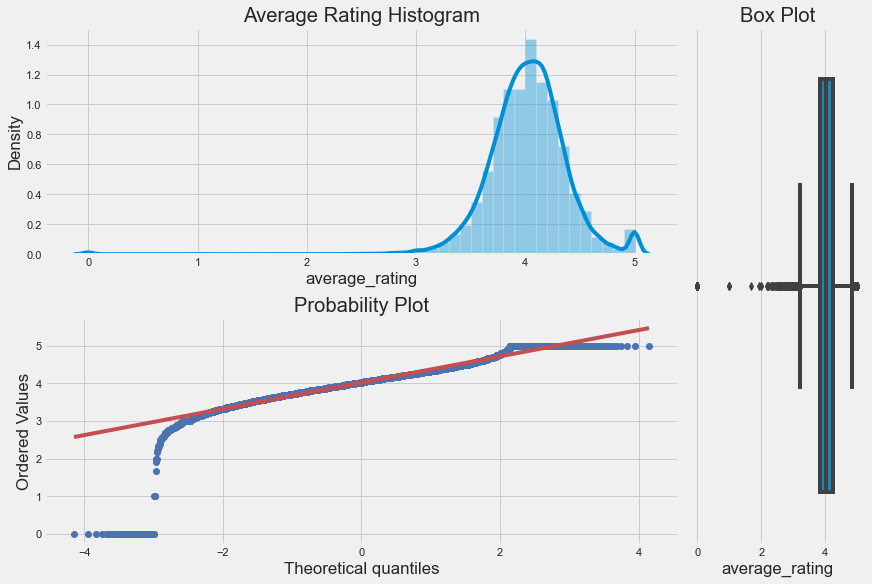

In [103]:
def plotting_3_chart(df, feature):
    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Average Rating Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
    
    
    
plotting_3_chart(y_target,'average_rating')

From these 3 charts, it can be observed several things about target variable 'average_rating' 
 - The target variable **average_rating** is noramlly distributed.
 - Eventually, the target variable has some outliers.

In [104]:
#skewness
print("Avg Rating Skewness: " + str(y_train['average_rating'].skew()))

Avg Rating Skewness: -1.836198722141747


## Visualizing numerical data

This part will only display data visualization in training dataset.

#### Histogram function

In [105]:
def histogram(df, feature):
    
     ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(20,12))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)
    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title(str(feature)+' Histogram ')
    ax1.legend(facecolor='white', fontsize=11)
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

#### Scatterplot function

In [106]:
def customized_scatterplot(y, x):
        ## Sizing the plot. 
    style.use('fivethirtyeight')
    plt.subplots(figsize = (12,8))
    plt.legend(facecolor='white', fontsize=11)
    ## Plotting target variable with predictor variable(OverallQual)
    sns.scatterplot(y = y, x = x);

## Review Count

No handles with labels found to put in legend.


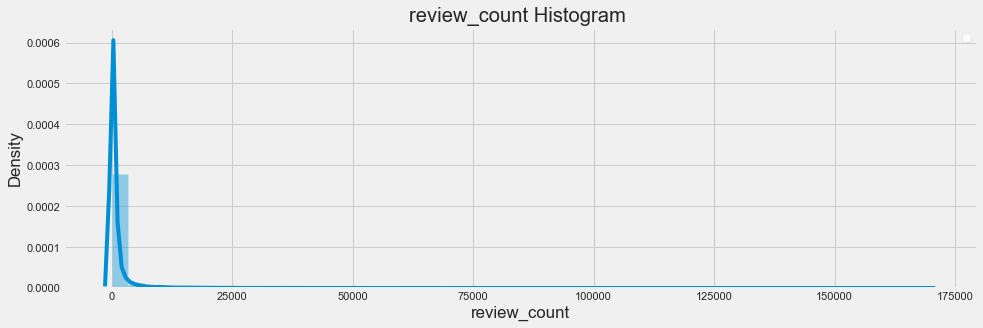

In [107]:
histogram(X_train, 'review_count')

In [108]:
print("Review Count Skewness: " + str(X_train['review_count'].skew()))

Review Count Skewness: 13.42431792970402


## Rating Count

No handles with labels found to put in legend.


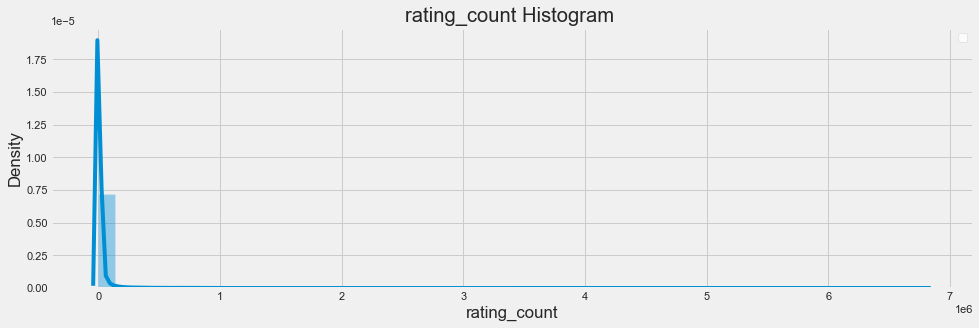

In [109]:
histogram(X_train, 'rating_count')

In [110]:
print("Rating Count Skewness: " + str(X_train['rating_count'].skew()))

Rating Count Skewness: 26.003731676838736


## Number of pages Count

No handles with labels found to put in legend.


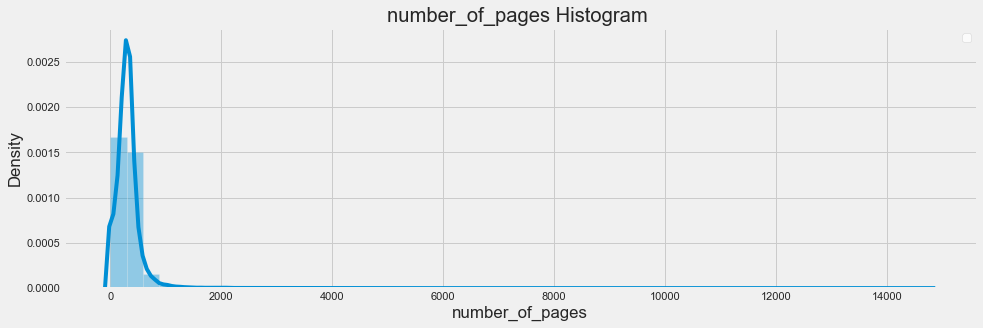

In [111]:
histogram(X_train, 'number_of_pages')

In [112]:
print("Book Pages Skewness: " + str(X_train['number_of_pages'].skew()))

Book Pages Skewness: 11.708073131496688


### Observation

I used histogram to check numerical data's distribution in training dataset. 

It can be observed that numerical data has quite positive skewess. This will affect on the efficience of linear regression. 

## Avg Rating vs Page Num

No handles with labels found to put in legend.


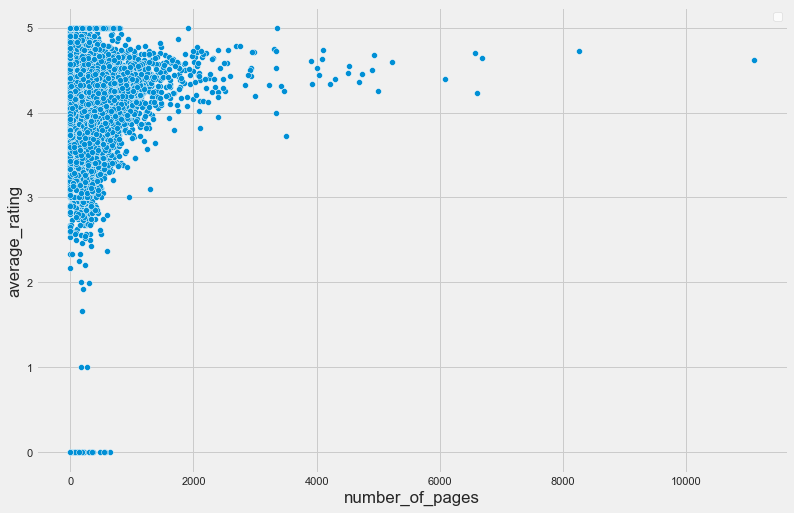

In [113]:
customized_scatterplot(y_train.average_rating, X_train.number_of_pages)

## Avg Rating vs Rating Count  

No handles with labels found to put in legend.


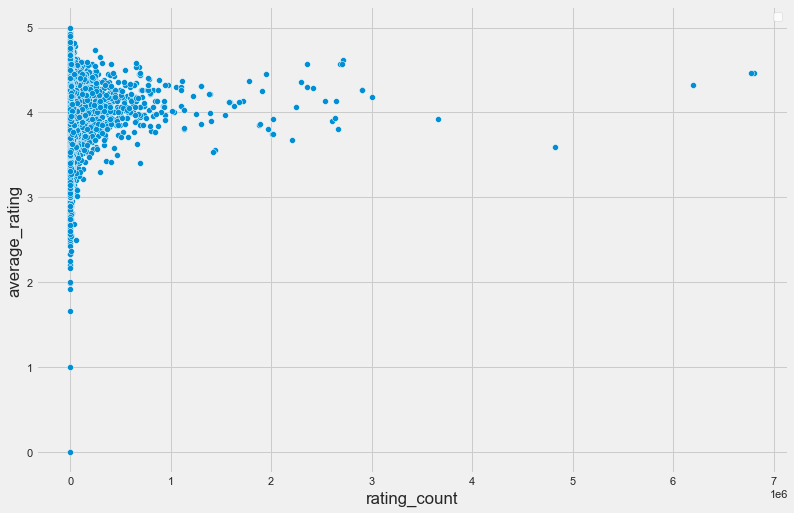

In [114]:
customized_scatterplot(y_train.average_rating, X_train.rating_count)

## Avg Rating vs Awards 

No handles with labels found to put in legend.


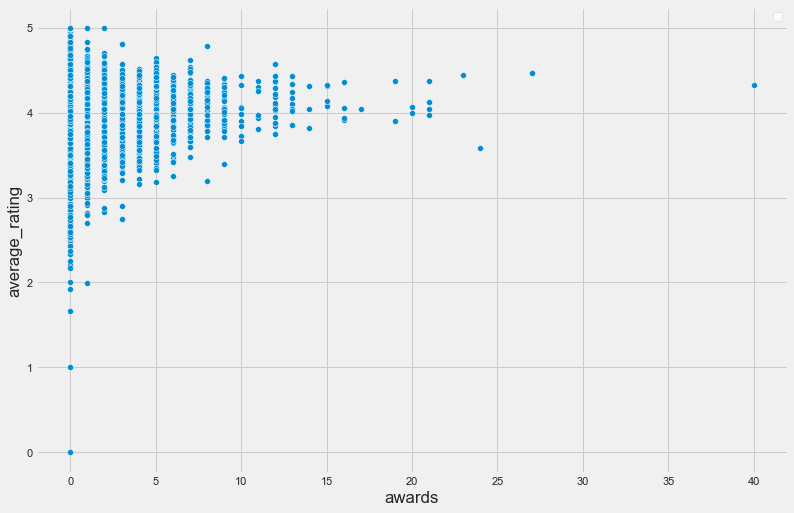

In [115]:
customized_scatterplot(y_train.average_rating, X_train.awards)

## Avg Rating vs Year Published 

No handles with labels found to put in legend.


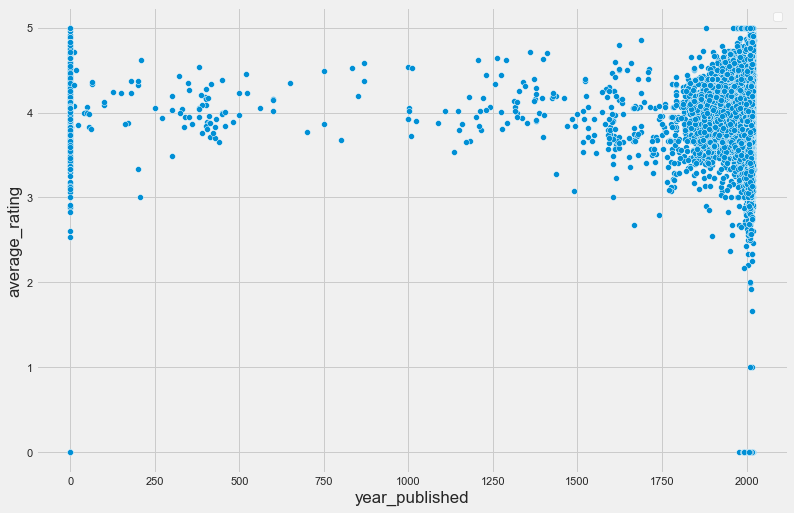

In [116]:
customized_scatterplot(y_train.average_rating, X_train.year_published) 

Average_rating is more gathered in modern period of years (2000s). 

Some outliers are seen in 0 and 1 rating scores. 

No handles with labels found to put in legend.


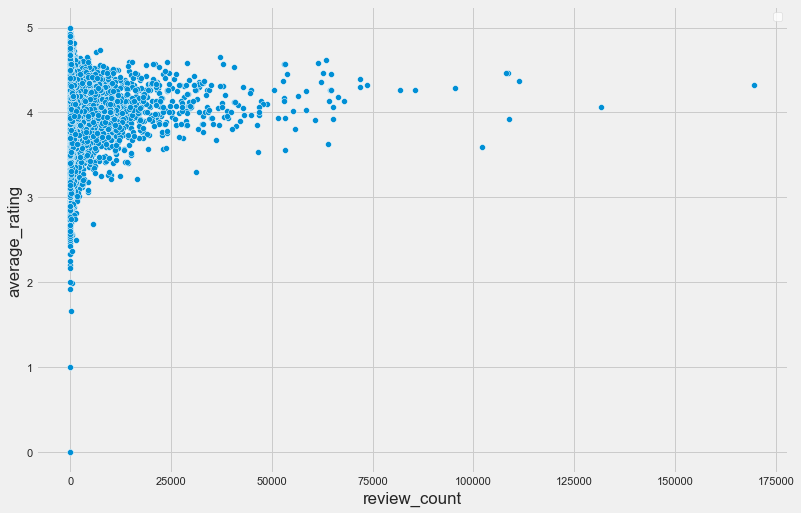

In [117]:
customized_scatterplot(y_train.average_rating, X_train.review_count) 





Eventhough scatterplot is not the most suitable one to visualize categorical data, I use scatterplot graph to demonstrate apparent relationship between the target variable and other features, 

## Observations: 

- There are many outliers in two above scatterplots due to the skewness of numerical data

- These graphs seem not follow any trends. I need to handle these skewness in dataset.

# Task 2: Feature Engineering 

# Fixing skewness 

In [118]:
from scipy.stats import skew

In [119]:
# finding skewness features in all_data to engineering
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)

skewed_feats

rating_count       24.695496
review_count       14.331460
number_of_pages    11.259385
awards              6.497303
id                  1.202380
year_published     -6.741225
dtype: float64

Due to 'award' and 'year_published' are cleaned and formated in previous part. Thus, I keep their original data.

In [120]:
skewed_feats = all_data[['review_count','rating_count','number_of_pages']]

In [121]:
## FiX_training Skewed features using boxcox transformation. 
def fixing_skewness(df):
    """
    This function takes in a dataframe and return fixed skewed dataframe
    """
    ## Import necessary modules 
    from scipy.stats import skew
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    ## Getting all the data that are not of "object" type. 
    numeric_feats = df.dtypes[df.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index

    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))


fixing_skewness(skewed_feats)

No handles with labels found to put in legend.


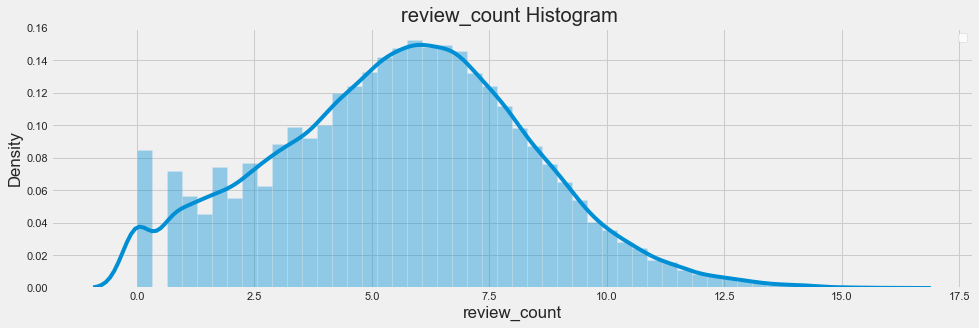

In [122]:
histogram(skewed_feats, 'review_count')

In [123]:
print("Review Count Skewness: " + str(skewed_feats['review_count'].skew()))

Review Count Skewness: 0.03592706226060209


No handles with labels found to put in legend.


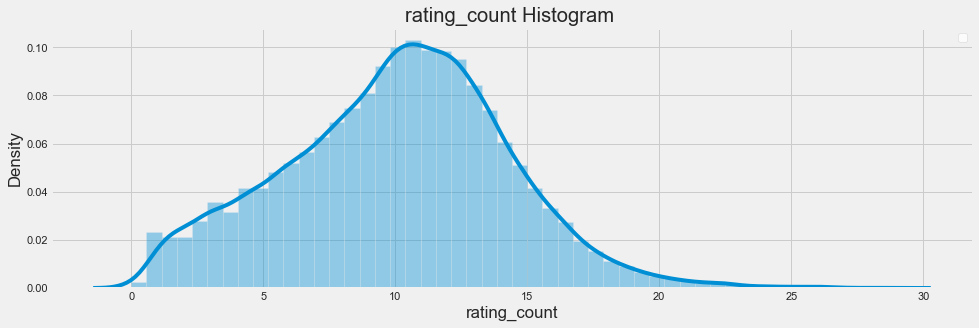

In [124]:
histogram(skewed_feats, 'rating_count')

In [125]:
print("Rating Count Skewness: " + str(skewed_feats['rating_count'].skew()))

Rating Count Skewness: 0.019995804938089473


No handles with labels found to put in legend.


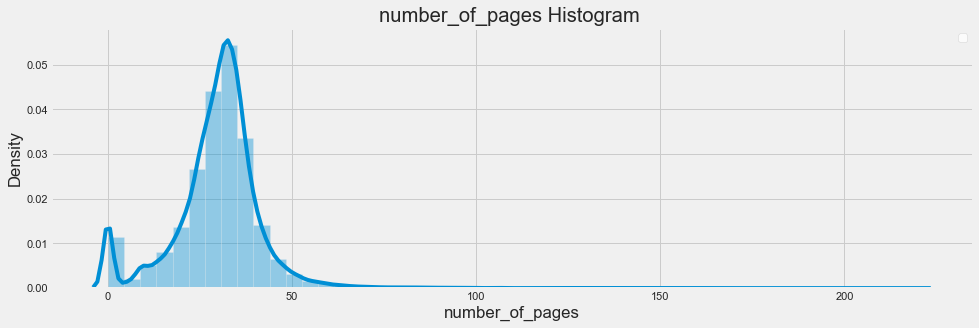

In [126]:
histogram(skewed_feats, 'number_of_pages')

In [127]:
print("Page Number Skewness: " + str(skewed_feats['number_of_pages'].skew()))

Page Number Skewness: 0.2941106378534157


In [128]:
len(skewed_feats)

52199

Now skewed features are more normally distributed and can be used for the models.

## Deleting features

#### Drop skewed features 

In [129]:
all_data.drop(columns=['rating_count','review_count', "number_of_pages"],axis=1,inplace=True)

In [130]:
all_data.head(2)

,id,series,year_published,publisher,genre,awards,description
0,2533958,none,1975.0,macmillan,history,0,including hilarious tales of the people he enc...
1,16071790,none,2013.0,doubleday canada,mystery,0,a searing and sinister thriller for readers wh...


In [131]:
# join fixed skewed data
all_data = all_data.join(skewed_feats)

In [132]:
# dataset with fixed skewness
all_data.head(2)

,id,series,year_published,publisher,genre,awards,description,review_count,rating_count,number_of_pages
0,2533958,none,1975.0,macmillan,history,0,including hilarious tales of the people he enc...,4.322761,7.873879,33.090681
1,16071790,none,2013.0,doubleday canada,mystery,0,a searing and sinister thriller for readers wh...,8.387966,12.991985,32.167972


Because of non-numerical features, I need to fit label encoding on train and test data seperatly. 

In [133]:
# Resplit all_data with skewd X_train
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(all_data, test_size = 0.2, random_state = 0)

In [134]:
len(X_train)

41759

In [135]:
len(X_test)

10440

# Label Encoding for non-numerical data

In [136]:
# Encoding non-numerical columns using LabalEncoder
from sklearn.preprocessing import LabelEncoder

# initializing labelencoder
le = LabelEncoder()

## Series feature

In [137]:
# encode 'series' feature in train set
X_train['series_encoded'] = le.fit_transform(X_train['series'])

# for any unseen label in train dataset
# map them to 'none'
X_test['series'] = X_test['series'].map(lambda s: 'none' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, 'none>')

# encode 'series' feature in testing dataset
# only call transform for the test
X_test['series_encoded'] = le.transform(X_test['series'])

## Publisher feature

In [138]:
X_train['publisher_encoded'] = le.fit_transform(X_train['publisher'])

#mapping unseen label to 'none'
X_test['publisher'] = X_test['publisher'].map(lambda s: 'none' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, 'none')

X_test['publisher_encoded'] = le.transform(X_test['publisher'])

## Genre feature

In [139]:
X_train['genre_encoded'] = le.fit_transform(X_train['genre'])

#mapping unseen label to 'none'
X_test['genre'] = X_test['genre'].map(lambda s: 'none' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, 'none')

X_test['genre_encoded'] = le.transform(X_test['genre'])

In [140]:
X_train[['series','series_encoded','publisher','publisher_encoded','genre','genre_encoded']].sample(10)

,series,series_encoded,publisher,publisher_encoded,genre,genre_encoded
29979,none,4917,harmony,3345,nonfiction,280
13617,none,4917,austral,624,cultural spain,115
48114,seductive nights,5854,lauren blakely books,4444,romance,345
17401,none,4917,melville house,4998,classics,72
38422,de kleine odessa,1760,van goor,8020,fantasy,169
9742,guardians of time,2903,bloomsbury children s books,1032,fantasy,169
22258,none,4917,vintage,8110,fiction,182
20490,none,4917,david c cook,1902,christian,63
792,wings,8804,harperteen,3478,fantasy,169
51401,none,4917,simon pulse,7088,young adult,432


In [141]:
X_test[['series','series_encoded','publisher','publisher_encoded','genre','genre_encoded']].sample(10)

,series,series_encoded,publisher,publisher_encoded,genre,genre_encoded
8397,pretty little liars,5339,harperteen,3478,mystery,267
32186,none,4917,st martin s press,7279,fiction,182
44818,the poldark saga,7675,fontana,2830,historical historical fiction,211
8311,none,4917,دار الفارابي,8895,novels,284
11024,none,4917,macmillan,4792,short stories,388
558,none,4917,quinta essência,6339,none,439
42445,none,4917,kessinger publishing,4244,short stories,388
47739,none,4917,putnam juvenile,6297,young adult,432
39299,queen of the orcs,5411,del rey,1966,fantasy,169
4786,none,4917,scribner,6882,fiction,182


# Combine X_train and y

In [142]:
df = pd.merge(X_train, y_train)

In [143]:
len(y_train)

41759

In [144]:
y_train.isna().sum()

id                0
average_rating    0
dtype: int64

In [145]:
# df = df.drop_duplicates()
# df.reset_index(inplace=True, drop=True)

In [146]:
df.isna().sum()

id                   0
series               0
year_published       0
publisher            0
genre                0
awards               0
description          0
review_count         0
rating_count         0
number_of_pages      0
series_encoded       0
publisher_encoded    0
genre_encoded        0
average_rating       0
dtype: int64

In [147]:
df.drop(columns=['id'],axis=1,inplace=True)

In [148]:
# correlation analysis
corrMatrix = df.corr()
corrMatrix.style.background_gradient(cmap='Greens')

,year_published,awards,review_count,rating_count,number_of_pages,series_encoded,publisher_encoded,genre_encoded,average_rating
year_published,1.000000,0.051800,0.135408,0.114440,0.235678,-0.017640,-0.053005,0.010004,-0.016778
awards,0.051800,1.000000,0.375972,0.338930,0.090404,-0.003934,-0.010394,-0.000673,-0.017514
review_count,0.135408,0.375972,1.000000,0.948936,0.260591,-0.032212,-0.024701,0.023502,-0.102971
rating_count,0.114440,0.338930,0.948936,1.000000,0.273292,-0.033162,-0.023873,-0.004157,-0.067534
number_of_pages,0.235678,0.090404,0.260591,0.273292,1.000000,-0.005020,-0.019287,-0.019580,0.033588
series_encoded,-0.017640,-0.003934,-0.032212,-0.033162,-0.005020,1.000000,0.045193,-0.023862,0.006253
publisher_encoded,-0.053005,-0.010394,-0.024701,-0.023873,-0.019287,0.045193,1.000000,-0.006746,-0.004562
genre_encoded,0.010004,-0.000673,0.023502,-0.004157,-0.019580,-0.023862,-0.006746,1.000000,-0.007393
average_rating,-0.016778,-0.017514,-0.102971,-0.067534,0.033588,0.006253,-0.004562,-0.007393,1.000000


In [149]:
(df.corr()**2)["average_rating"].sort_values(ascending = False)[1:]

review_count         0.010603
rating_count         0.004561
number_of_pages      0.001128
awards               0.000307
year_published       0.000282
genre_encoded        0.000055
series_encoded       0.000039
publisher_encoded    0.000021
Name: average_rating, dtype: float64

## Observation:

- Despite of doing some feature engineering, correlation is not enough efficient for the target variable 'avg_rating' at all.

- Consequently, I will take feature extraction on 'description' feature. 

## Seperate label columns

In [150]:
X_train = df.copy()
del(X_train['average_rating'])
y_train = df['average_rating']

In [151]:
y_train.head(2)

0    4.42
1    3.96
Name: average_rating, dtype: float64

In [152]:
len(y_train)

33403

# Feature Extraction

### Textual mining on 'decription' feature on X_train and y_train 

In [153]:
np.random.seed(0)

In [154]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, shuffle=True)

In [155]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(26722, 12)
(6681, 12)
(26722,)
(6681,)


#### Tokenizing text function

In [156]:
# lower, tokenize and stem
def text_tokenize(text):
    text = text.lower()
    word_tokens = nltk.word_tokenize(text) 
    stop_words = set(stopwords.words('english'))
    stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
    filtered_sentence = [w for w in word_tokens if not w in stop_words]  
    stems = []
    for item in filtered_sentence:
        stems.append(PorterStemmer().stem(item))
    return stems

In [157]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=text_tokenize)

In [158]:
%%time
# use fit_transform with the train set
X_train_tfidf = vectorizer.fit_transform(X_train['description'])

#call the transform with the test set
X_val_tfidf = vectorizer.transform(X_val['description'])

Wall time: 2min 31s


In [159]:
X_train_tfidf = X_train_tfidf[:, X_train_tfidf.getnnz(0) > 100]
X_val_tfidf = X_val_tfidf[:, X_train_tfidf.getnnz(0) > 100]

In [160]:
X_train_tfidf = pd.DataFrame(X_train_tfidf.todense())
X_val_tfidf = pd.DataFrame(X_val_tfidf.todense())

In [161]:
X_train_tfidf.shape

(26722, 2673)

In [162]:
X_val_tfidf.shape

(6681, 2673)

### Sentiment score  

In [163]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [164]:
# get the sentiment scores
X_train_sent = X_train['description'].apply(lambda x: sid.polarity_scores(x))
X_val_sent = X_val['description'].apply(lambda x: sid.polarity_scores(x))

In [165]:
# convert to pd dataframes and transpose
X_train_sent = pd.DataFrame.from_dict(dict(X_train_sent)).T.reset_index(drop=True)
X_val_sent = pd.DataFrame.from_dict(dict(X_val_sent)).T.reset_index(drop=True)

In [166]:
# concat 2 feature types
X_train_combine = X_train_sent.join(X_train_tfidf)
X_val_combine = X_val_sent.join(X_val_tfidf)

In [167]:
len(X_train_combine)

26722

In [168]:
len(X_val_combine)

6681

In [169]:
y_train.shape

(26722,)

# Feature Selection summary

According to feature engineering and feature extraction, in order to apply efficient features for the best model's result. I will select several observed features to train and predict.

- Linear Regression:
    - rating_count
    - review_count 
- Xgboost Model: 
    - description

In [170]:
# dropping object columns
X_train = X_train[['year_published','awards','review_count','rating_count','number_of_pages','series_encoded','publisher_encoded','genre_encoded']]
X_train.head(2)

,year_published,awards,review_count,rating_count,number_of_pages,series_encoded,publisher_encoded,genre_encoded
11855,2002.0,0,5.174993,12.538968,25.706636,2348,8170,384
27747,2017.0,0,5.722177,9.000810,31.325269,4917,5377,215


# Task 3: Data Modelling

# Xgboost Model

## Train the model on X_train and y_train

In [171]:
import sklearn.metrics as metrics
import xgboost

In [172]:
start = time.time()
model = xgboost.XGBRegressor()
model = model.fit(X_train_tfidf,y_train)
stop = time.time()
time_XG = stop - start
time_XG

107.50123739242554

In [173]:
y_pred = model.predict(X_val_tfidf)

In [174]:
# The mean absolute error
MAE_XG = metrics.mean_absolute_error(y_pred, y_val)
# The mean squared error
RMSE_XG = metrics.mean_squared_error(y_pred, y_val)
# The coefficient of determination: 1 is perfect prediction
R2_XG = metrics.r2_score(y_pred, y_val)
print("MAE: ", MAE_XG)
print("RMSE: ", RMSE_XG)
print("R2: ", R2_XG)

MAE:  0.2597717684090735
RMSE:  0.12819600680689158
R2:  -84.76296249185704


## Retrain the model with sentiment scores

In [175]:
start = time.time()
model = xgboost.XGBRegressor()
model = model.fit(X_train_combine,y_train)
stop = time.time()
time_sent = stop - start
time_sent

104.77424597740173

In [176]:
# Make predictions using the testing set
y_pred = model.predict(X_val_combine)

In [177]:
# The mean absolute error
MAE_sent = metrics.mean_absolute_error(y_pred, y_val)
# The mean squared error
RMSE_sent = metrics.mean_squared_error(y_pred, y_val)
# The coefficient of determination: 1 is perfect prediction
R2_sent = metrics.r2_score(y_pred, y_val)
print("MAE: ", MAE_sent)
print("RMSE: ", RMSE_sent)
print("R2: ", R2_sent)

MAE:  0.2597717684090735
RMSE:  0.12819600680689158
R2:  -84.76296249185704


# Linear Regression

## Fit the model with 'review_count' features

In [178]:
# use fix training skeness features
X_train_one = np.array(X_train['review_count'])
y_train = np.array(y_train)

In [179]:
X_train_one.shape

(26722,)

In [180]:
y_train.shape

(26722,)

In [181]:
# reshape to avoid errors
X_train_one = X_train_one.reshape(len(X_train_one),1)
y_train = y_train.reshape(len(y_train),1)

In [182]:
#split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_one, y_train, test_size=0.2, random_state=0, shuffle=True)

In [183]:
len(X_train)

21377

In [184]:
model = linear_model.LinearRegression()
start = time.time()
model.fit(X_train, y_train)
stop = time.time()
time_SL = stop - start
time_SL

0.08199048042297363

In [185]:
y_pred = model.predict(X_val)

In [186]:
# The mean absolute error
MAE_SL = metrics.mean_absolute_error(y_pred, y_val)
# The mean squared error
RMSE_SL = metrics.mean_squared_error(y_pred, y_val)
# The coefficient of determination: 1 is perfect prediction
R2_SL = metrics.r2_score(y_pred, y_val)
print("MAE: ", MAE_SL)
print("RMSE: ", RMSE_SL)
print("R2: ", R2_SL)

MAE:  0.2571370094988154
RMSE:  0.13037191559918093
R2:  -106.85173871779178


# Multiple Linear Regression

In [187]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [188]:
np.random.seed(0)

In [189]:
model = linear_model.LinearRegression()
start = time.time()
model.fit(X_train, y_train)
stop = time.time()
time_ML = stop - start
time_ML

0.0010223388671875

In [190]:
y_pred = model.predict(X_val)

In [191]:
# The mean absolute error
MAE_ML = metrics.mean_absolute_error(y_pred, y_val)
# The mean squared error
RMSE_ML = metrics.mean_squared_error(y_pred, y_val)
# The coefficient of determination: 1 is perfect prediction
R2_ML = metrics.r2_score(y_pred, y_val)
print("MAE: ", MAE_ML)
print("RMSE: ", RMSE_ML)
print("R2: ", R2_ML)

MAE:  0.25939538657672556
RMSE:  0.13098809878783368
R2:  -114.66908180891188


# Polinomial Regression

In [192]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
model = Pipeline([('poly', PolynomialFeatures(degree=8)),
                  ('linear', linear_model.LinearRegression())])

start = time.time()
model = model.fit(X_train,y_train)
stop = time.time()
time_PR = stop - start
time_PR

0.03099846839904785

In [193]:
# Make predictions using the testing set
y_pred = model.predict(X_val)

In [194]:
# The mean absolute error
MAE_PR = metrics.mean_absolute_error(y_pred, y_val)
# The mean squared error
RMSE_PR = metrics.mean_squared_error(y_pred, y_val)
# The coefficient of determination: 1 is perfect prediction
R2_PR = metrics.r2_score(y_pred, y_val)
print("MAE: ", MAE_PR)
print("RMSE: ", RMSE_PR)
print("R2: ", R2_PR)

MAE:  0.25827367196360357
RMSE:  0.12991408304258736
R2:  -49.68076915279156


In [195]:
# print result table
table = {'Model': ['XgBoost','XgBoost with Sentiment scores','Simple Linear Regression','Multiple Linear Regression', 'Polinomial Regression'],     
         
         'RMSE': [RMSE_XG,RMSE_sent,RMSE_SL, RMSE_ML, RMSE_PR,],
         'MAE': [ MAE_XG,MAE_sent,MAE_SL, MAE_ML, MAE_PR],
         'R2': [ R2_XG,R2_sent,R2_SL, R2_ML, R2_PR],
         'Training Time': [time_XG,time_sent,time_SL,time_ML,time_PR]
        }
Result_table = pd.DataFrame (table, columns = ['Model','RMSE','MAE','R2', 'Training Time'])
print(Result_table)

                           Model      RMSE       MAE          R2  \
0                        XgBoost  0.128196  0.259772  -84.762962   
1  XgBoost with Sentiment scores  0.128196  0.259772  -84.762962   
2       Simple Linear Regression  0.130372  0.257137 -106.851739   
3     Multiple Linear Regression  0.130988  0.259395 -114.669082   
4          Polinomial Regression  0.129914  0.258274  -49.680769   

   Training Time  
0     107.501237  
1     104.774246  
2       0.081990  
3       0.001022  
4       0.030998  


# Final Observations: 

According to the table of results: 
   - I have tried 5 models including TF-IDF, XgBoost and Linear Regression
   - It can be seen that the most efficient model is Polyminal Regression to predict avg_rating scores. 